In [1]:
import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import skew
from scipy.spatial.distance import cityblock

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata

import matplotlib.pyplot as plt
import seaborn as sns


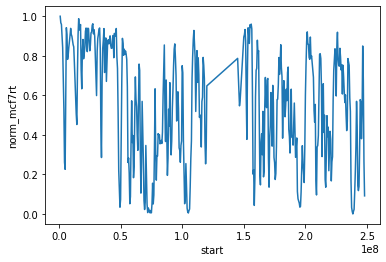

In [3]:
rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)
plt.show()

In [4]:
starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
gc = rtdata['gc'].values
num_cells = 170
num_loci = 400

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
gc = torch.tensor(gc[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in the first 30 bins
cn[:30, :30] = 1

# assign cells to 2 different libraries
libs = torch.randint(2, (num_cells,)).to(torch.int64)

In [7]:
def make_gc_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)

softplus = torch.nn.Softplus()
relu = torch.nn.ReLU()

@config_enumerate
def model_g1(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        # u should be inversely related to cn, positively related to reads
        if (data is not None) and (cn is not None):
            cell_ploidies = torch.mean(cn.type(torch.float32), dim=0)
            u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.

        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))
        
        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            # gc_rate = gc_rate / torch.mean(gc_rate)
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [8]:

@config_enumerate
def model_S(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, poly_degree=4, data=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None, t_init=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape
    num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.param('a', torch.tensor([10.]))
    
    # negative binomial dispersion
    nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # gc bias params
    # these should be conditioned based on fitted values for G1-phase cells
    beta_means = pyro.sample('beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('t', dist.Beta(t_alpha_prior, t_beta_prior))
        elif t_init is not None:
            t = pyro.param('t', t_init, constraint=constraints.unit_interval)
        else:
            t = pyro.sample('t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
            # u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))
            
            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2)k)
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

# trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
# trace.compute_log_prob()
# print(trace.format_shapes())
# pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
#                   render_distributions=True, render_params=True)

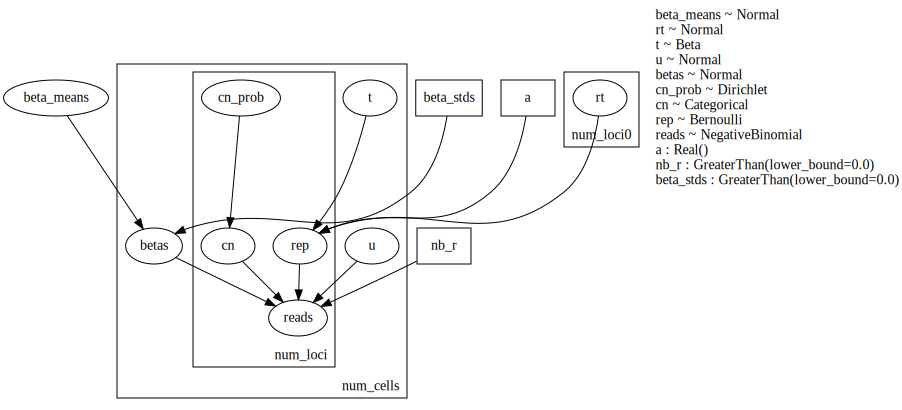

In [12]:
trace = poutine.trace(model_S).get_trace(gc, libs, None, num_cells=num_cells, num_loci=num_loci)
trace.compute_log_prob()
# print(trace.format_shapes())
pyro.render_model(model_S, model_args=(gc, libs, None, None, num_cells, num_loci), 
                  render_distributions=True, render_params=True)

In [19]:
@config_enumerate
def model_s(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, cn_prior=None, nb_r_guess=10000., t_alpha_prior=None, t_beta_prior=None, t_init=None, poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([nb_r_guess]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    # define cell and loci plates
    loci_plate = pyro.plate('num_loci', num_loci, dim=-2)
    cell_plate = pyro.plate('num_cells', num_cells, dim=-1)

    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with loci_plate:
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with cell_plate:

        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            time = pyro.sample('expose_time', dist.Beta(t_alpha_prior, t_beta_prior))
        elif t_init is not None:
            time = pyro.param('expose_time', t_init, constraint=constraints.unit_interval)
        else:
            time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
            # u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))
        
#         # per cell replication time
#         # draw from prior if provided
#         if (t_alpha_prior is not None) and (t_beta_prior is not None):
#             time = pyro.sample('expose_time', dist.Beta(t_alpha_prior, t_beta_prior))
#         elif t_init is not None:
#             time = pyro.param('expose_time', t_init, constraint=constraints.unit_interval)
#         else:
#             time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))

#         # per cell reads per copy per bin
#         # u should be inversely related to time and cn, positively related to reads
#         if cn0 is not None:
#             cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
#         elif cn_prior is not None:
#             temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
#             cell_ploidies = torch.mean(temp_cn0, dim=0)
#         else:
#             cell_ploidies = torch.ones(num_cells) * 2.
#             u_guess = 
#         u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + time) * cell_ploidies)
#         u_stdev = u_guess / 10.

#         u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))

        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with loci_plate:

            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('expose_cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob), infer={"enumerate": "parallel"})

            # per cell per bin late or early 
            t_diff = time.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep), infer={"enumerate": "parallel"})

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

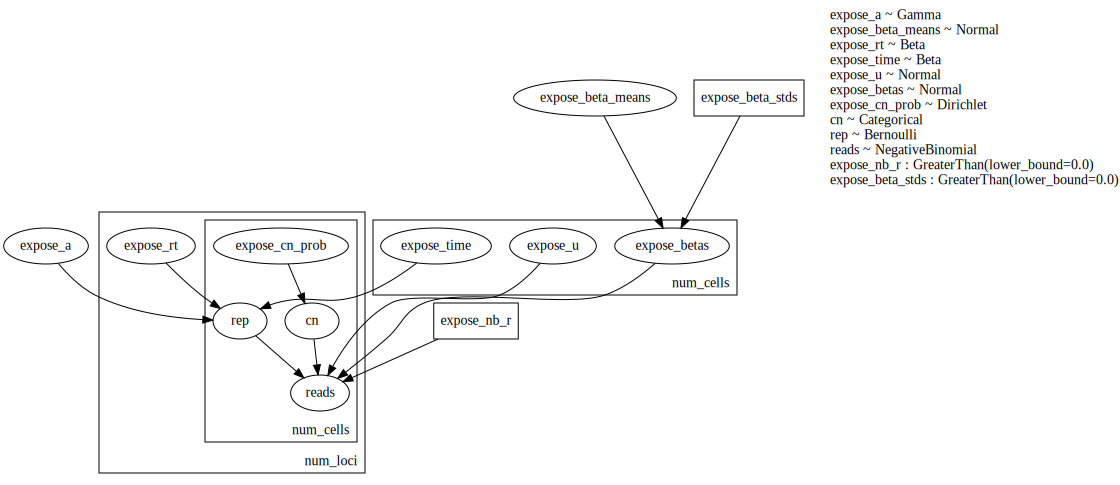

In [25]:
trace = poutine.trace(model_s).get_trace(gc, libs, None, num_cells=num_cells, num_loci=num_loci)
trace.compute_log_prob()
# print(trace.format_shapes())
pyro.render_model(model_s, model_args=(gc, libs, None, None, num_cells, num_loci), 
                  render_distributions=True, render_params=True,
                  filename="pert_model_s.png"
                 )

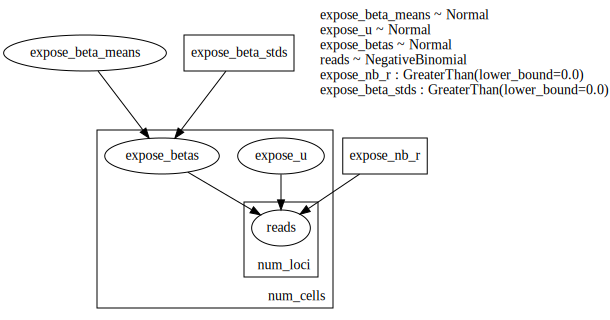

In [26]:
# trace = poutine.trace(model_g1).get_trace(gc, libs, None, num_cells=num_cells, num_loci=num_loci)
# trace.compute_log_prob()
# print(trace.format_shapes())
#gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, poly_degree=4
pyro.render_model(model_g1, model_args=(gc, libs, cn, num_cells, num_loci), 
                  render_distributions=True, render_params=True, filename="pert_model_g.png")